In [5]:
import importlib
import terrain
importlib.reload(terrain)

<module 'terrain' from '/media/afriesinger/Volume/Projekte/Gleitschirmfliegen/Studium/Programming/SciProFinal/terrain.py'>

In [6]:
# Load terrain data from the 30m GeoTiff
terrain_data, lats, lons, resolution_m = terrain.load_terrain_from_tif()

print(f"\nTerrain shape: {terrain_data.shape}")
print(f"Resolution: ~{resolution_m}m")
print(f"Elevation range: {terrain_data.min()}m to {terrain_data.max()}m")

Loaded terrain: (7641, 25469), resolution ~30m
  Bounds: lat(45.00, 48.00), lon(6.00, 16.00)

Terrain shape: (7641, 25469)
Resolution: ~30m
Elevation range: -32768m to 4672m


In [7]:
# Downsample to 1km resolution
terrain_1km, lats_1km, lons_1km, resolution_1km = terrain.downsample_terrain(
    terrain_data, lats, lons, resolution_m, target_resolution_m=1000
)

print(f"\n1km terrain shape: {terrain_1km.shape}")
print(f"Resolution: ~{resolution_1km}m")

Downsampled: (7641, 25469) -> (232, 772), resolution ~990m

1km terrain shape: (232, 772)
Resolution: ~990m


In [8]:
# Compute terrain aspect dataset
terrain_ds = terrain.compute_terrain_aspect_dataset(
    terrain=terrain_1km,
    lats=lats_1km,
    lons=lons_1km,
    resolution_m=resolution_1km,
    min_elevation=500.0,
    min_slope=1.0
)

print(terrain_ds)
print(f"\nTerrain mask coverage: {terrain_ds['terrain_mask'].values.sum() / terrain_ds['terrain_mask'].size * 100:.1f}%")

<xarray.Dataset> Size: 6MB
Dimensions:       (latitude: 232, longitude: 772)
Coordinates:
  * latitude      (latitude) float64 2kB 48.0 47.99 47.97 ... 45.03 45.01 45.0
  * longitude     (longitude) float64 6kB 6.0 6.013 6.026 ... 15.97 15.99 16.0
Data variables:
    elevation     (latitude, longitude) float64 1MB 325.5 324.3 ... 0.0
    aspect        (latitude, longitude) float64 1MB 0.4185 0.4487 ... -0.4974
    aspect_deg    (latitude, longitude) float64 1MB 23.98 25.71 ... 336.4 331.5
    slope         (latitude, longitude) float64 1MB 0.5596 0.6074 ... 7.956
    terrain_mask  (latitude, longitude) bool 179kB False False ... False False
Attributes:
    resolution_m:   990
    min_elevation:  500.0
    min_slope:      1.0
    description:    Terrain slope aspect dataset computed from SRTM data

Terrain mask coverage: 49.5%


In [ ]:
# Save terrain aspect dataset to NetCDF
output_path = "./terrain_cache/terrain_aspect_1km.nc"
terrain_ds.to_netcdf(output_path)
print(f"Saved terrain aspect dataset to {output_path}")

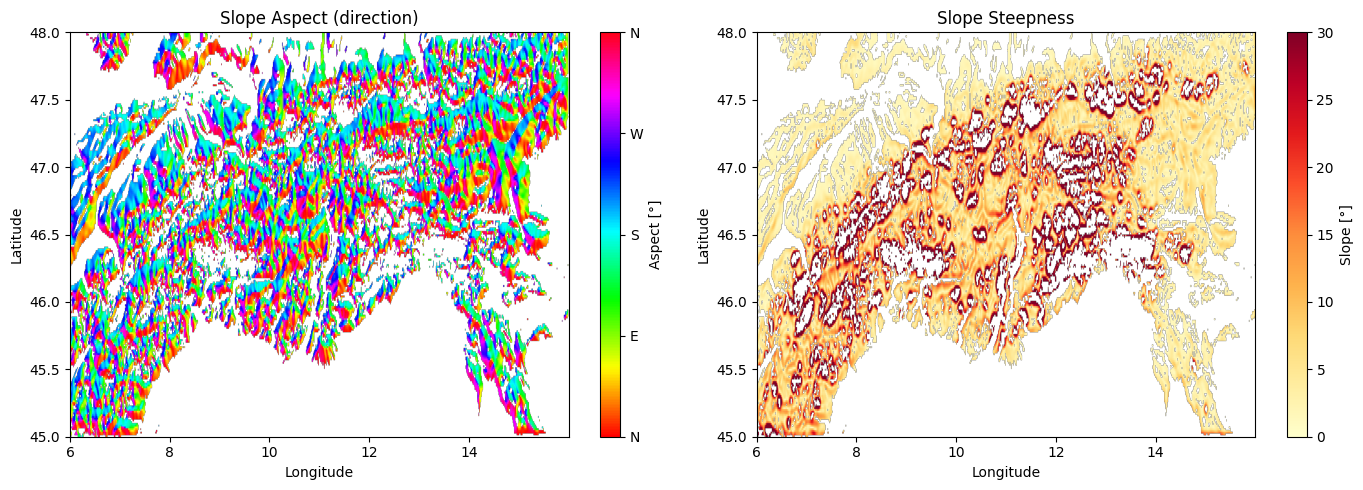

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Aspect plot (circular colormap)
ax1 = axes[0]
aspect_data = np.where(terrain_ds['terrain_mask'], terrain_ds['aspect_deg'], np.nan)
im1 = ax1.imshow(aspect_data, extent=[lons_1km[0], lons_1km[-1], lats_1km[-1], lats_1km[0]], 
                  cmap='hsv', vmin=0, vmax=360, aspect='auto')
ax1.set_title('Slope Aspect (direction)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
cbar1 = plt.colorbar(im1, ax=ax1, label='Aspect [°]', ticks=[0, 90, 180, 270, 360])
cbar1.ax.set_yticklabels(['N', 'E', 'S', 'W', 'N'])

# Slope plot
ax2 = axes[1]
slope_data = np.where(terrain_ds['terrain_mask'], terrain_ds['slope'], np.nan)
im2 = ax2.imshow(slope_data, extent=[lons_1km[0], lons_1km[-1], lats_1km[-1], lats_1km[0]], 
                  cmap='YlOrRd', vmin=0, vmax=30, aspect='auto')
ax2.set_title('Slope Steepness')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Slope [°]')

plt.tight_layout()
plt.show()

In [ ]:
##Example usage to add terrain intersection to ERA5 data
terrain_ds = terrain.load_terrain_aspect_dataset()
era5_path = "./era5vis-main/era5vis/data/era5_example_dataset.nc"
era5_data = xr.open_dataset(era5_path)
era5_with_terrain = terrain.compute_terrain_intersection(era5_data, terrain_ds)